# Classes list

In [87]:
_100_classes_raw = [
    "beaver, dolphin, otter, seal, whale",
    "aquarium fish, flatfish, ray, shark, trout",
    "orchids, poppies, roses, sunflowers, tulips",
    "bottles, bowls, cans, cups, plates",
    "apples, mushrooms, oranges, pears, sweet peppers",
    "clock, computer keyboard, lamp, telephone, television",
    "bed, chair, couch, table, wardrobe",
    "bee, beetle, butterfly, caterpillar, cockroach",
    "bear, leopard, lion, tiger, wolf",
    "bridge, castle, house, road, skyscraper",
    "cloud, forest, mountain, plain, sea",
    "camel, cattle, chimpanzee, elephant, kangaroo",
    "fox, porcupine, possum, raccoon, skunk",
    "crab, lobster, snail, spider, worm",
    "baby, boy, girl, man, woman",
    "crocodile, dinosaur, lizard, snake, turtle",
    "hamster, mouse, rabbit, shrew, squirrel",
    "maple, oak, palm, pine, willow",
    "bicycle, bus, motorcycle, pickup truck, train",
    "lawn-mower, rocket, streetcar, tank, tractor"
]

classes_100 = [item.strip() for group in _100_classes_raw for item in group.split(",")]
len(classes_100)


100

In [88]:
_100_classes_raw = [
    "beaver, dolphin, otter, seal, whale",
    "aquarium fish, flatfish, ray, shark, trout",
    "orchids, poppies, roses, sunflowers, tulips",
    "bottles, bowls, cans, cups, plates",
    "apples, mushrooms, oranges, pears, sweet peppers",
    "clock, computer keyboard, lamp, telephone, television",
    "bed, chair, couch, table, wardrobe",
    "bee, beetle, butterfly, caterpillar, cockroach",
    "bear, leopard, lion, tiger, wolf",
    "bridge, castle, house, road, skyscraper",
    "cloud, forest, mountain, plain, sea",
    "camel, cattle, chimpanzee, elephant, kangaroo",
    "fox, porcupine, possum, raccoon, skunk",
    "crab, lobster, snail, spider, worm",
    "baby, boy, girl, man, woman",
    "crocodile, dinosaur, lizard, snake, turtle",
    "hamster, mouse, rabbit, shrew, squirrel",
    "maple, oak, palm, pine, willow",
    "bicycle, bus, motorcycle, pickup truck, train",
    "lawn-mower, rocket, streetcar, tank, tractor"
]

classes_100 = [item.strip() for group in _100_classes_raw for item in group.split(",")]
len(classes_100)


100

# Setup

## Device

In [89]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Define the model

In [90]:
import torch.nn as nn
import transformers

class ViT(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        
        # Set output_attentions=True to get attention scores
        vit_args = transformers.ViTConfig(
            hidden_size=256, 
            num_hidden_layers=6, 
            num_attention_heads=4,
            # num_attention_heads=1,
            intermediate_size=256 * 2, 
            hidden_act='gelu', 
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.0, 
            initializer_range=0.02,
            layer_norm_eps=1e-12, 
            is_encoder_decoder=False, 
            image_size=args.img_size,
            patch_size=args.patch_size, 
            num_channels=args.num_channels, 
            qkv_bias=True,
            output_attentions=True,  # Enable attention outputs
            attn_implementation="eager"
        )

        self.encoder = transformers.ViTModel(vit_args)
        self.clf = nn.Linear(256, args.num_classes)

    def forward(self, x, attn_flag = False):
        # Get the output from the encoder
        outputs = self.encoder(x)
        
        # Attention scores are stored in outputs.attentions (a list of tensors)
        if attn_flag:
            attentions = outputs.attentions
        
        # Pooler output: Use the output of the CLS token
        x = outputs.pooler_output
        
        # Pass through the classifier
        x = self.clf(x)
        
        if attn_flag:
            return x, attentions
        else:
            return x
        
        


In [91]:
# import torch.nn as nn
# import transformers

class Pretrained_ViT(nn.Module):
    def __init__(self):
        super().__init__()
        
       
        
        # Load the pretrained ViT model from Hugging Face
        self.encoder = transformers.ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224-in21k',   # Pretrained on ImageNet-21k       # CIFAR-100 has 100 classes,
            output_attentions=True,  # Enable attention outputs
            attn_implementation="eager",
            num_labels=100, 
        )

    def forward(self, x, attn_flag = False):
        # Get the output from the encoder
        #         x, attentions = self.encoder(x)
        # Get the output from the encoder
        outputs = self.encoder(x)  # outputs is a dictionary-like object

        # Extract logits and attentions
        logits = outputs.logits   # Get the logits tensor (predictions)
        attentions = outputs.attentions  # Get the attention maps if needed
        
        

        
        if attn_flag:
            return logits, attentions
        else:
            return logits
        
        


In [92]:
# requires torchvision >= 0.13, "DEFAULT" means best available

def get_Pretrained_Vit():
  # 2. Setup a ViT model instance with pretrained weights
  pretrained_vit = Pretrained_ViT().to(device)

    #   # 3. Freeze the base parameters
  for parameter in pretrained_vit.parameters():
      parameter.requires_grad = False

  # 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
  # set_seeds()
  torch.manual_seed(42)

  import torch.nn as nn
  pretrained_vit.encoder.classifier = nn.Linear(in_features=768, out_features=len(classes_100)).to(device)
  # pretrained_vit # uncomment for model output
  return pretrained_vit

# pretrained_vit = get_vit()

In [93]:
# !pip3 install transformers

## Dataloaders

In [94]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import torch


def get_loaders(args):
    train_augmentations = [transforms.Resize(args.img_size)]
    if args.padding > 0:
        train_augmentations += [transforms.RandomCrop(args.img_size, padding=args.padding)]
    if args.hflip:
        train_augmentations += [transforms.RandomHorizontalFlip()]
    train_augmentations += [transforms.ToTensor(), transforms.Normalize(mean=args.mean, std=args.std)]
    train_augmentations = transforms.Compose(train_augmentations)

    if args.dataset.lower().startswith('cifar'):
        train_dataset = datasets.__dict__[args.dataset.upper()](root=os.path.join(args.data_path, args.dataset), train=True, download=True, transform=train_augmentations)
    elif args.dataset == 'fmnist':
        train_dataset = datasets.FashionMNIST(root=os.path.join(args.data_path, args.dataset), train=True, download=True, transform=train_augmentations)
    elif args.dataset == 'svhn':
        train_dataset = datasets.SVHN(root=os.path.join(args.data_path, args.dataset), split='train', download=True, transform=train_augmentations)
    else:
        train_dataset = datasets.ImageFolder(root=os.path.join(args.data_path, args.dataset, 'train'), transform=train_augmentations)

    test_augmentations = transforms.Compose([transforms.Resize(args.img_size),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=args.mean, std=args.std)])

    if args.dataset.lower().startswith('cifar'):
        val_dataset = datasets.__dict__[args.dataset.upper()](root=os.path.join(args.data_path, args.dataset), train=False, download=True, transform=test_augmentations)
    elif args.dataset == 'fmnist':
        val_dataset = datasets.FashionMNIST(root=os.path.join(args.data_path, args.dataset), train=False, download=True, transform=test_augmentations)
    elif args.dataset == 'svhn':
        val_dataset = datasets.SVHN(root=os.path.join(args.data_path, args.dataset), split='test', download=True, transform=test_augmentations)
    else:
        val_dataset = datasets.ImageFolder(root=os.path.join(args.data_path, args.dataset, 'val'), transform=test_augmentations)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=args.batch_size,
                                               shuffle=True,
                                               num_workers=args.workers,
                                               drop_last=True)

    val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=args.batch_size,
                                             shuffle=False,
                                             num_workers=args.workers,
                                             drop_last=False)
    return train_loader, val_loader

## Utils

In [95]:
import torch
import torch.nn.functional as F
import numpy as np
# from sklearn.metrics import confusion_matrix, top_k_accuracy_score
import math


def patchswap(args, x1, y1, alpha=1.0):
    m = x1.shape[0]

    new_idx = torch.randperm(m)
    x2 = x1[new_idx]
    y2 = y1[new_idx]

    x1 = x1.unfold(2, args.patch_size, args.patch_size).unfold(3, args.patch_size, args.patch_size)
    x1 = x1.reshape(-1, args.num_channels, args.num_patches, args.patch_size, args.patch_size)

    x2 = x2.unfold(2, args.patch_size, args.patch_size).unfold(3, args.patch_size, args.patch_size)
    x2 = x2.reshape(-1, args.num_channels, args.num_patches, args.patch_size, args.patch_size)

    lam = np.random.beta(alpha, alpha)

    x1_frames_count = round(lam * args.num_patches)
    lam_new = x1_frames_count / args.num_patches

    rand_probs = torch.rand(m, args.num_patches).to(device)

    if x1_frames_count > 0:
        thresh = -torch.kthvalue(-rand_probs, x1_frames_count, -1, keepdims=True)[0]
    else:
        thresh = torch.Tensor([1.1]).to(device)

    swap = rand_probs >= thresh
    swap = swap.reshape(m, 1, args.num_patches, 1, 1)
    x = x1 * swap + x2 * (~swap)

    x = x.contiguous().view(m, args.num_channels, -1, args.patch_size * args.patch_size)
    x = x.permute(0, 1, 3, 2)
    x = x.contiguous().view(m, args.num_channels * args.patch_size * args.patch_size, -1)
    x = F.fold(x, output_size=(args.img_size, args.img_size), kernel_size=args.patch_size, stride=args.patch_size)

    return x, y1, y2, lam_new


def patchswap_loss(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b) + lam * np.log(lam + 1e-6) + (1 - lam) * np.log(1 - lam + 1e-6)


def accuracy(args, target, output, k=5):
    top1 = top_k_accuracy_score(target, output, k=1, labels=range(0, args.num_classes))
    topk = top_k_accuracy_score(target, output, k=k, labels=range(0, args.num_classes))
    return top1, topk


def cmatrix(args, target, predict):
    return confusion_matrix(target, np.array(predict).argmax(1), labels=range(0, args.num_classes))


def adjust_learning_rate(optimizer, epoch, args):
    lr = args.lr
    if epoch < args.warmup:
        lr = lr / (args.warmup - epoch)
    else:
        lr *= 0.5 * (1. + math.cos(math.pi * (epoch - args.warmup) / (args.epochs - args.warmup)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    print(f'Epoch: {epoch}\tlr: {lr}')

# Training

In [96]:
import argparse
from time import time
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import json
import os
import numpy as np



def init_parser():
    args = argparse.Namespace()
    args.data_path = './data/'
    args.dataset = 'cifar10'
    args.patch_size = 4
    args.model_path = './model/'

    args.epochs = 120
    args.warmup = 10
    args.lr = 5e-4
    args.batch_size = 128
    args.weight_decay = 3e-2
    return args

def update_args(args, config):   

    # Update arguments with values from the config file
    args.img_size = config["img_size"]
    args.hflip = config["hflip"]
    args.num_channels = config["num_channels"]
    args.num_classes = config["num_classes"]
    args.cm = config["cm"]
    args.padding = config["padding"]
    args.mean = config["mean"]
    args.std = config["std"]
    args.dataset = config['dataset']
    args.num_attention_heads=config["num_attention_heads"]
    
    
    args.epochs = config["epochs"]

    # Update other settings
    args.is_cuda = torch.cuda.is_available()
    args.num_patches = (args.img_size // args.patch_size) ** 2
    args.model_path = os.path.join(args.model_path, args.dataset)
    
    # Create model directory if it doesn't exist
    os.makedirs(args.model_path, exist_ok=True)

    # Set number of workers based on available CPU cores
    args.workers = max(os.cpu_count() - 2, 1)
    
    return args



def print_args(args):
    for k in dict(sorted(vars(args).items())).items():
        print(k)
    print()


In [97]:
# model

In [98]:

def train_step(args, train_loader, model, criterion, optimizer):

    model.train()
    iter_per_epoch = len(train_loader)
    actual, predict, losses = [], [], []
    for i, (x, y) in enumerate(train_loader):
        if args.is_cuda:
            x = x.to(device)
            y = y.to(device)

        x_mix, y1, y2, lam = patchswap(args, x, y)
        output = model(x_mix)
        loss = patchswap_loss(criterion, output, y1, y2, lam)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0 or i == iter_per_epoch-1:
            loss = loss.item() + lam * np.log(lam+1e-6) + (1-lam) * np.log(1-lam+1e-6)
        #   print(f'It: {i+1}/{iter_per_epoch}\tLoss: {loss:.4f}')


def test_step(args, loader, model, criterion):
    model.eval()
    actual, predict, losses = [], [], []

    with torch.no_grad():
        for (x, y) in loader:
            if args.is_cuda:
                x = x.to(device)

            output = model(x)

            losses += criterion(output, y.to(device)).tolist()
            actual += y.tolist()
            predict += output.tolist()
    acc1, acc5 = accuracy(args, actual, predict)
    avg_loss = sum(losses)/len(losses)
    cm = cmatrix(args, actual, predict)

    return acc1, acc5, cm, avg_loss


In [99]:
''''Type-1 for traibed from scratch cifar 100 4 heads
Type -2 for trained from scratch cifar 100 1 head
Type-3 pretrained  model 
'''

def update_config(config,type):
    if(type==1): #cifar 100 4 head
        config["img_size"]=32
        config[ "num_classes"]=100
        config[ "dataset"]='cifar100'
        config[ "num_classes"]=100
        config["num_attention_heads"]=4
    elif(type==2): #cifar 100 1 head
        config["img_size"]=32
        config[ "num_classes"]=100
        config[ "dataset"]='cifar100'
        config[ "num_classes"]=100
        config["num_attention_heads"]=1
    elif(type==3): #pretrained no FT
        config["img_size"]=32
        config[ "num_classes"]=100
        config[ "dataset"]='cifar100'
        config[ "num_classes"]=100
        config["num_attention_heads"]=4
        
    elif(type==4): #pretrained FT
        raise Exception("Not implemented yet, fix update_config function")
        config["img_size"]=224
        config[ "num_classes"]=21,841
        # config[ "dataset"]='cifar100'
        # config["num_attention_heads"]=1

    





In [100]:
from tqdm import tqdm

In [101]:
# # pretrained_vit
# def load_model_state_dict(model, relative_path_to_checkpoints="../Pretrained_checkpoints", filename="model_state.pth"):
#     """
#     Load the state dictionary of a pretrained model from a sibling directory.

#     Parameters:
#         model: The model object to load the state dictionary into.
#         relative_path_to_checkpoints: Relative path from the current directory to the checkpoint directory (default: '../Pretrained_checkpoints').
#         filename: The name of the checkpoint file (default: 'model_state.pth').

#     Returns:
#         None
#     """
#     # Create the full path relative to the current directory
#     file_path = os.path.join(relative_path_to_checkpoints, filename)
    
#     # Load the state dictionary
#     # Load the state dictionary
#     # print(file_path)
#     model_state_dict = torch.load(file_path, map_location='cpu', weights_only=True)
#     model.load_state_dict(model_state_dict)
#     print(f"Model loaded from {file_path}")


In [102]:
import os
import torch

def load_model_state_dict(model, relative_path_to_checkpoints="../Pretrained_checkpoints", filename="model_state.pth"):
    """
    Load the state dictionary of a pretrained model from a sibling directory.

    Parameters:
        model: The model object to load the state dictionary into.
        relative_path_to_checkpoints: Relative path from the current directory to the checkpoint directory (default: '../Pretrained_checkpoints').
        filename: The name of the checkpoint file (default: 'model_state.pth').

    Returns:
        None
    """
    # Create the full path relative to the current directory
    file_path = os.path.join(relative_path_to_checkpoints, filename)
    
    # Load the state dictionary
    model_state_dict = torch.load(file_path, map_location='cpu')  # Removed weights_only=True
    
    # Attempt to load the state dict with strict=False to allow for mismatched keys
    missing_keys, unexpected_keys = model.load_state_dict(model_state_dict, strict=False)
    
    # Print out missing and unexpected keys for debugging
    if missing_keys:
        print(f"Missing keys in the model: {missing_keys}")
    if unexpected_keys:
        print(f"Unexpected keys in the state_dict: {unexpected_keys}")
    
    print(f"Model loaded from {file_path}")


In [103]:
args = init_parser()
config = {
    "img_size": 32,           # CIFAR-10 image size (32x32)
    #  "img_size": 256, 
    "hflip": True,            # Horizontal flip augmentation (common for CIFAR-10)
    "num_channels": 3,        # CIFAR-10 has 3 channels (RGB)
    # "num_classes": 10,        # CIFAR-10 has 10 classes
     "num_classes": 100,        # CIFAR-10 has 10 classes
    "cm": False,  
    
    "dataset":'cifar100',  
    #  "dataset":'cifar10',      
    #     "dataset":'fmnist',
    "padding": 4,             # Typical padding used in CIFAR-10 augmentation
    "mean": [0.4914, 0.4822, 0.4465],  # Precomputed mean values for CIFAR-10 (RGB)
    "std": [0.2023, 0.1994, 0.2010]  ,  # Precomputed standard deviation for CIFAR-10 (RGB)
    "epochs"  : 120 , 
}


In [104]:

MODEL_TYPE=1   ## MODEL TYPE 1 - FOR Trained from scratch with 32*32 size images 
               ## MODEL TYPE-2 - FOR PRETRAINED with 224*224 size images.

In [105]:
'''IGNORE THIS CELL'''
if MODEL_TYPE == 1:
    state_dict_file = "cifar100_4head.pth"
    _classes  = classes_100
elif MODEL_TYPE == 2:
    state_dict_file = "cifar100_1head.pth"
    _classes  = classes_100
elif MODEL_TYPE == 3:
    state_dict_file = "pretrain_ft_cifar100.pth"
elif MODEL_TYPE == 4:
    state_dict_file = "cifar100_4head.pth"



# load_model_state_dict(model, relative_path_to_checkpoints=os.path.join('..', 'Pretrained_checkpoints'), filename=state_dict_file)
# model.eval()

In [106]:
# model

In [107]:


update_config(config,type=MODEL_TYPE)

args = update_args(args, config)

print_args(args)


model = ViT(args)

optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

criterion = nn.CrossEntropyLoss()
criterion_ = nn.CrossEntropyLoss(reduction='none')

if args.is_cuda:
    model = model.to(device)

# model.load_state

('batch_size', 128)
('cm', False)
('data_path', './data/')
('dataset', 'cifar100')
('epochs', 120)
('hflip', True)
('img_size', 32)
('is_cuda', False)
('lr', 0.0005)
('mean', [0.4914, 0.4822, 0.4465])
('model_path', './model/cifar100')
('num_attention_heads', 4)
('num_channels', 3)
('num_classes', 100)
('num_patches', 64)
('padding', 4)
('patch_size', 4)
('std', [0.2023, 0.1994, 0.201])
('warmup', 10)
('weight_decay', 0.03)
('workers', 10)



# Visualisation

In [108]:
import os
import numpy as np

def load_data_from_directory(directory_path):
    """Load images, labels, outputs, and image IDs from the specified directory."""

    
    try:
        # Construct the full paths for each file
        ids_path = os.path.join(directory_path, 'ids.npy')
        images_path = os.path.join(directory_path, 'images.npy')
        labels_path = os.path.join(directory_path, 'labels.npy')
        outputs_path = os.path.join(directory_path, 'outputs.npy')

        # Load the numpy arrays
        img_ids = np.load(ids_path)
        images = np.load(images_path)
        labels = np.load(labels_path)
        outputs = np.load(outputs_path)

        return img_ids, images, labels, outputs

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None, None

# Example usage
directory_path = '../saved_images/correct'  # Adjust as needed
img_ids, images, labels, outputs = load_data_from_directory(directory_path)
preds = np.argmax(outputs,-1)


# Example to check the loaded data
if images is not None:
    print(f"Loaded {images.shape[0]} images, {labels.shape[0]} labels, {outputs.shape[0]} outputs, {img_ids.shape[0]} image IDs.")


Loaded 5 images, 5 labels, 5 outputs, 5 image IDs.


In [109]:
preds, labels

(array([3, 8, 0, 6, 6], dtype=int64), array([3, 8, 0, 6, 6], dtype=int64))

In [110]:
classes=['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck']

Label: 6
Label class: frog
Output: 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


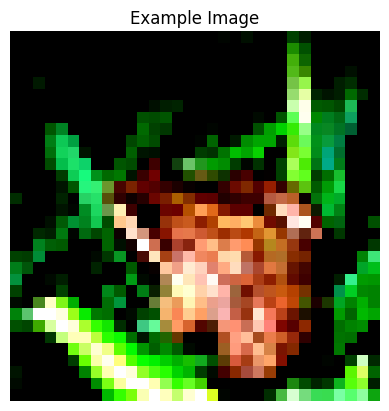

In [111]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image(image_idx, title=None):
    """
    Plot a single image using Matplotlib.

    Args:
        image (numpy.ndarray): The image to plot. It should be in the format (height, width, channels).
        title (str, optional): The title for the plot. Defaults to None.

    Returns:
        None
    """

    # Print label and output
    print(f"Label: {labels[image_idx]}")
    print(f"Label class: {classes[labels[image_idx]]}")
    print(f"Output: {preds[image_idx]}")

    image = images[image_idx]

    if image.ndim == 3 and image.shape[2] == 3:
        # Color image
        plt.imshow(image)
    elif image.ndim == 2 or (image.ndim == 3 and image.shape[2] == 1):
        # Grayscale image
        if image.ndim == 3:
            image = image.squeeze()  # Remove the channel dimension
        plt.imshow(image, cmap='gray')
    else:
        raise ValueError("Image format not recognized. Expected (H, W) or (H, W, 3) or (H, W, 1).")

    if title:
        plt.title(title)
    
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
# Assuming `images` is a numpy array of images with shape (k, H, W, C)
# and you want to plot the first image:
image_idx = 3
plot_image(image_idx, title="Example Image")


In [112]:
from PIL import Image
import cv2
from skimage.transform import resize




def Img_Downsample(image,type=1):
   

# Assuming 'image' is the loaded image object from PIL



    if(type==1):
        resized_image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)
    elif(type==2):
        resized_image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_CUBIC)
    elif(type==3):
        resized_image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_LINEAR)
    else:
        resized_image = resize(image, (32, 32), anti_aliasing=True)

    
    plt.imshow(resized_image)
    plt.axis('off')  # Optional: Hide the axes for a cleaner view
    plt.show()





    return resized_image

        



In [113]:
def image_merging(image1_idx,image2_idx,method):

    # image1_idx=3
    # image2_idx=4

    image1=images[image1_idx:image1_idx+1]

    image2=images[image2_idx:image2_idx+1]

    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    if(method=='hstack'):
        combined_image = np.hstack((image1, image2))
        plt.imshow(combined_image)
        plt.axis('off')  # Hide axes for better visualization
        plt.show()
    else:
        combined_image = np.vstack((image1, image2))
        plt.imshow(combined_image)
        plt.axis('off')  # Hide axes for better visualization
        plt.show()

    return combined_image
# plot_image(image_idx, title="Example Image")

In [114]:
# image2.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


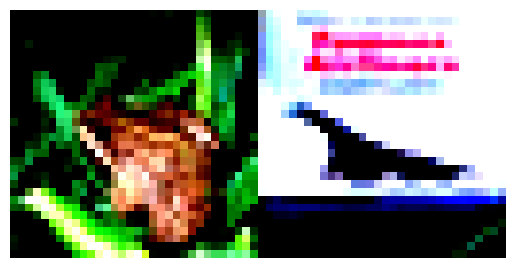

In [115]:
combined_image=image_merging(image1_idx=3,image2_idx=2,method="hstack")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


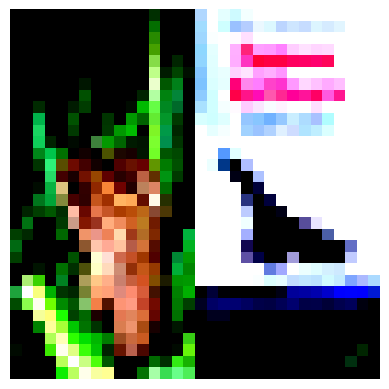

(1, 32, 32, 3)

In [116]:
combined_image=Img_Downsample(combined_image,type=1)
combined_image.shape
combined_image=np.expand_dims(np.transpose(combined_image, (0, 1, 2)), axis=0)
combined_image.shape

In [117]:
img=combined_image

In [118]:
image=combined_image[0]

In [119]:
image.shape

(32, 32, 3)

In [120]:
# import numpy as np
# from PIL import Image
# from torchvision import transforms
# from torchvision.transforms import InterpolationMode

# def scale_up(image):
#     # Ensure input image is a NumPy array of shape (32, 32, 3)
#     assert image.shape == (32, 32, 3), "Input image must be of shape (32, 32, 3)"

#     # Define the transforms to resize and normalize the image
#     pretrained_vit_transforms = transforms.Compose([
#         transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),  # Resize to 256x256
#         transforms.CenterCrop(224),  # Crop to 224x224
#         transforms.ToTensor(),  # Convert image to tensor
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
#     ])

#     # Scale to [0, 255] and convert to uint8
#     image_np = (image * 255).astype(np.uint8)

#     # Convert the NumPy array to a PIL Image
#     image_pil = Image.fromarray(image_np)

#     # Apply the transformations (resize, crop, normalize)
#     transformed_image = pretrained_vit_transforms(image_pil)
    
#     return transformed_image


In [121]:
# import numpy as np
# import torch
# from torchvision import transforms
# from PIL import Image
# from torchvision.transforms import InterpolationMode

# def scale_up(image):
#     # Ensure input image is a NumPy array of shape (1, 3, 32, 32)
#     assert image.shape == (1, 3, 32, 32), "Input image must be of shape (1, 3, 32, 32)"
    
#     # Remove the batch dimension and transpose to HWC format
#     image_np = np.transpose(image[0], (1, 2, 0))  # Shape becomes (32, 32, 3)

#     # Convert the NumPy array to a PIL Image
#     image_pil = Image.fromarray((image_np * 255).astype(np.uint8))

#     # Define the transforms to resize and normalize the image
#     pretrained_vit_transforms = transforms.Compose([
#         transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),  # Resize to 256x256
#         transforms.CenterCrop(224),  # Crop to 224x224
#         transforms.ToTensor(),  # Convert image to tensor
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
#     ])

#     # Apply the transformations
#     transformed_image = pretrained_vit_transforms(image_pil)

#     # Add the batch dimension back
#     transformed_image = transformed_image.unsqueeze(0)  # Shape becomes (1, 3, 224, 224)

#     return transformed_image

# # Example usage:
# input_image = np.random.rand(1, 3, 32, 32)  # Example input as NumPy array
# transformed_image = scale_up(input_image)
# print("Transformed image shape:", transformed_image.shape)


# import numpy as np
# from torchvision import transforms
# from PIL import Image
# from torchvision.transforms import InterpolationMode

# def scale_up(image):
#     # Ensure input image is a NumPy array of shape (1, 3, 32, 32)
#     assert image.shape == (1, 3, 32, 32), "Input image must be of shape (1, 3, 32, 32)"
    
#     # Remove the batch dimension and transpose to HWC format
#     image_np = np.transpose(image[0], (1, 2, 0))  # Shape becomes (32, 32, 3)

#     # Convert the NumPy array to a PIL Image
#     image_pil = Image.fromarray((image_np * 255).astype(np.uint8))
#     # image_pil = torch.tensor(image_np).float()  # Shape becomes (3, 32, 32)

#     # Define the transforms to resize and normalize the image
#     pretrained_vit_transforms = transforms.Compose([
#         transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),  # Resize to 256x256
#         transforms.CenterCrop(224),  # Crop to 224x224
#         transforms.ToTensor(),  # Convert image to tensor
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
#     ])

#     # Apply the transformations
#     transformed_image_tensor = pretrained_vit_transforms(image_pil)

#     # Convert the tensor back to NumPy array
#     transformed_image = transformed_image_tensor.numpy()  # Shape becomes (3, 224, 224)

#     # Add the batch dimension back and change the shape to (1, 3, 224, 224)
#     transformed_image = np.expand_dims(transformed_image, axis=0)  # Shape becomes (1, 3, 224, 224)

#     return transformed_image

# # Example usage:
# input_image = np.random.rand(1, 3, 32, 32)  # Example input as NumPy array
# transformed_image = scale_up(input_image)
# print("Transformed image shape:", transformed_image.shape)
# print(type(transformed_image))


In [122]:
import numpy as np
import torch
from torchvision import transforms
import torchvision.transforms.functional as F

def scale_up(image):
    # Ensure input image is a NumPy array of shape (1, 3, 32, 32)
    assert image.shape == (1, 3, 32, 32), "Input image must be of shape (1, 3, 32, 32)"
    
    # Convert NumPy array to PyTorch tensor and remove batch dimension
    image_tensor = torch.tensor(image[0]).float()  # Shape becomes (3, 32, 32)

    # Resize to 256x256 and center crop to 224x224
    image_tensor = F.resize(image_tensor, [256, 256], interpolation=transforms.InterpolationMode.BILINEAR)
    image_tensor = F.center_crop(image_tensor, [224, 224])

    # Normalize using ImageNet statistics
    image_tensor = F.normalize(image_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # Add the batch dimension back
    transformed_image = image_tensor.unsqueeze(0)  # Shape becomes (1, 3, 224, 224)
    transformed_image = transformed_image.numpy()  # Shape becomes (3, 224, 224)

#     # Add the batch dimension back and change the shape to (1, 3, 224, 224)
#     transformed_image = np.expand_dims(transformed_image, axis=0)  # Shape becomes (1, 3, 224, 224)

    return transformed_image

# Example usage:
input_image = np.random.rand(1, 3, 32, 32)  # Example input as NumPy array
transformed_image = scale_up(input_image)
print("Transformed image shape:", transformed_image.shape)
print(type(transformed_image))


Transformed image shape: (1, 3, 224, 224)
<class 'numpy.ndarray'>


c:\Users\pande\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [123]:
# type=3
# if(type==3):
#      # Convert float array to uint8 (you may need to multiply by 255 to scale values)
#     image_np = (image * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

#     # Convert NumPy array to PIL Image
#     image = Image.fromarray(image_np)

#     transformed_image = pretrained_vit_transforms(image)
   

# transformed_image.shape


In [124]:
# type(image)

In [125]:
# from PIL import Image
# import numpy as np

# # Load the image
# image = Image.open('../saved_images/correct/hybrid.jpeg')

# # Convert image to NumPy array
# image_array = np.array(image)

# print(image_array)

In [126]:
# image_array.shape

In [127]:
# type(img_one)

In [128]:
# img_one=image

In [129]:
# raise EOFError

In [130]:
# image = np.expand_dims(image, axis=0)
# image=image.astype(np.float32)

In [131]:
image.shape

(32, 32, 3)

In [132]:

if(MODEL_TYPE==1):
    image=np.expand_dims(np.transpose(image, (2, 0, 1)), axis=0)
else:

    image=scale_up(image)
    print(image.shape)
    # image=np.expand_dims(np.transpose(image, (2, 0, 1)), axis=0)
    image=np.expand_dims(image, axis=0)


image.shape

(1, 3, 32, 32)

In [133]:
# image=np.expand_dims(np.transpose(image, (2, 0, 1)), axis=0)

In [134]:
# image.shape

In [135]:
# raise EOFError

In [136]:
# img_one=image

In [137]:
# img_one.shape

In [138]:
img_one=image

In [139]:
img_one.shape

(1, 3, 32, 32)

In [140]:
# img_one = np.transpose(img_one, (0, 2, 3, 1))
img_one.shape

(1, 3, 32, 32)

In [141]:
# img_one=combined_image
img_one.shape

(1, 3, 32, 32)

In [142]:
# attns_list = []
# model.eval()

# with torch.inference_mode():
#     out = model(torch.tensor(img_one))
#     # print(img_one.shape)
    
    

# attns = torch.stack(attns_list)
# attns = attns.squeeze(dim=1) #remove the image dimension
# attns = attns.permute(1, 0, 2, 3)  # new shape is head x layer x q x k
# attns.shape

In [143]:
images.shape

(5, 32, 32, 3)

In [144]:
image_idx
images[image_idx:image_idx+1].shape


(1, 32, 32, 3)

# Getting Attention maps

In [145]:

pass

In [146]:
# img_one = images[image_idx:image_idx+1]

In [147]:
# img_one.shape

In [148]:
# img=img_one

In [149]:
# attentions[0].shape

In [150]:
# resize_transform = transforms.Resize((224, 224))
# upsampled_image = resize_transform(image)

In [151]:
# type=3
# if(type==3):
#     transformed_image = pretrained_vit_transforms(image)

# transformed_image.shape


In [152]:
import torch

# Define batch size and image dimensions
batch_size = 4
num_channels = 3  # RGB channels
image_height = 32
image_width =32

# image_height = 224
# image_width =224

# Generate a random tensor to simulate input images
# input_images = torch.randn(batch_size, num_channels, image_height, image_width)

# print(input_images.shape)
# --------------------------------------------------
# print(img_one.shape)
model.eval()
# outputs, attentions = model(input_images.to(device),True)
# out, attentions = model(torch.tensor(np.transpose(img_one, (0, 3, 1, 2))),True)
out, attentions = model(torch.tensor(img_one),True)
# attentions.shape

# Example: Access the attention scores for layer 3, head 1
layer_idx = 2  # Layer index (0-based)
head_idx = 0   # Head index (0-based)

specific_head_attention = attentions[layer_idx][:, head_idx, :, :]
print(specific_head_attention)
specific_head_attention.shape
specific_head_attention[0,1].shape



tensor([[[0.0163, 0.0151, 0.0149,  ..., 0.0150, 0.0152, 0.0156],
         [0.0156, 0.0131, 0.0130,  ..., 0.0137, 0.0134, 0.0141],
         [0.0159, 0.0135, 0.0131,  ..., 0.0139, 0.0136, 0.0146],
         ...,
         [0.0159, 0.0141, 0.0133,  ..., 0.0143, 0.0140, 0.0144],
         [0.0156, 0.0139, 0.0133,  ..., 0.0141, 0.0139, 0.0143],
         [0.0161, 0.0125, 0.0122,  ..., 0.0128, 0.0124, 0.0137]]],
       grad_fn=<SliceBackward0>)


torch.Size([65])

# Getting layerwise and headwise attention weights


In [153]:
import torch

def get_attention_map_for_query(attentions, layer_idx, head_idx, query_patch_idx):
    """
    Extracts the attention map for a specific query patch at a given layer and head index.

    Args:
        attentions (torch.Tensor): The attention tensor of shape (num_layers, batch_size, num_heads, seq_len, seq_len).
        layer_idx (int): The index of the layer (0-based).
        head_idx (int): The index of the head (0-based).
        query_patch_idx (int): The index of the query patch (0-based).

    Returns:
        torch.Tensor: The attention weights for the specified query patch.
    """
    attns = [i.squeeze(0).detach() for i in attentions]
    attns = torch.stack(attns).permute(1, 0, 2,3)
    # print(attns.shape)
    # print(attns[head_idx][layer_idx][query_patch_idx].shape)

    return attns[head_idx][layer_idx][query_patch_idx]

    
    # return attention_for_query_patch.squeeze()

get_attention_map_for_query(attentions, layer_idx=0, head_idx=0, query_patch_idx=0)


tensor([0.0147, 0.0141, 0.0143, 0.0144, 0.0135, 0.0167, 0.0161, 0.0163, 0.0165,
        0.0142, 0.0144, 0.0149, 0.0140, 0.0166, 0.0149, 0.0152, 0.0164, 0.0147,
        0.0152, 0.0149, 0.0141, 0.0169, 0.0168, 0.0167, 0.0169, 0.0169, 0.0135,
        0.0151, 0.0142, 0.0156, 0.0160, 0.0167, 0.0168, 0.0171, 0.0148, 0.0159,
        0.0140, 0.0167, 0.0142, 0.0161, 0.0167, 0.0153, 0.0165, 0.0154, 0.0146,
        0.0165, 0.0146, 0.0151, 0.0169, 0.0159, 0.0176, 0.0157, 0.0135, 0.0141,
        0.0146, 0.0152, 0.0156, 0.0148, 0.0152, 0.0163, 0.0160, 0.0143, 0.0138,
        0.0141, 0.0151])

In [154]:
# out, attentions = model(torch.tensor(np.transpose(img_one, (0, 3, 1, 2))),True)

In [155]:
specific_head_attention.shape

torch.Size([1, 65, 65])

In [156]:
# attns=specific_head_attention


In [157]:
# len(attns)

In [158]:
attns = [i.squeeze(0).detach() for i in attentions]
attns = torch.stack(attns).permute(1, 0, 2,3)


In [159]:
attns.shape

torch.Size([4, 6, 65, 65])

In [160]:
import cv2

In [161]:
def get_threshold(attn_grid,threshold,quantile_value=0.9):
    if threshold == 'mean':
        threshold = attn_grid.mean()
    elif threshold == 'median':
        threshold = attn_grid.median()
    elif threshold == 'decile':
        threshold = torch.quantile(attn_grid, 0.9)
    # elif threshold == 'otsu':
    #     # maximise interclass seperation
    #     # threshold, _ = cv2.threshold(attn_grid.cpu().numpy(), 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #     threshold = ski.filters.threshold_otsu(attn_row.cpu().numpy())
        # attn_grid = torch.tensor(binary_map, dtype=torch.float32)
    elif threshold == 'other':
        # Adjust quantile_value to get the top x% where x = quantile_value * 100
        threshold = torch.quantile(attn_grid, quantile_value)
    else:
        threshold = threshold # You can adjust this threshold as needed
    return threshold

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Define rainbow colors from violet to red
rainbow_colors = [
    (148/255, 0/255, 211/255),  # violet
    (75/255, 0/255, 130/255),   # indigo
    (0/255, 0/255, 255/255),    # blue
    (0/255, 255/255, 0/255),    # green
    (255/255, 255/255, 0/255),  # yellow
    (255/255, 127/255, 0/255),  # orange
    (255/255, 0/255, 0/255)     # red
]
# Create the colormap
rainbow_cmap = LinearSegmentedColormap.from_list("rainbow_cmap", rainbow_colors)


In [163]:
# # Example data for the heatmap
# data = np.random.rand(10, 10)  # Random 10x10 matrix

# # Plot the heatmap with the custom colormap
# plt.imshow(data, cmap=rainbow_cmap, interpolation='nearest')
# plt.colorbar(label="Intensity")
# plt.title("Rainbow Heatmap: Violet (low) to Red (high)")
# plt.show()


In [164]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_attn_heatmap(attn_row, q_idx, binary=False, threshold = 0.5, figsize = (4, 4),normalize_flag = False, ax=None, overlay = False,quantile_value=0.9,model_type=1, img = None):
    # Ensure the tensor is of shape (65,)
    # assert attn_row.shape == (65,), "attn_row should have a shape of (65,)"
    
    # Remove the first element (corresponding to the [CLS] token if present)
    attn_grid = attn_row[1:]
    
    # Scaling of all values in attn_grid
    if normalize_flag:
        # print("normalized")
        attn_grid = (attn_grid - attn_grid.min()) / (attn_grid.max() - attn_grid.min())
    
    # attn_grid += 
    # Apply binary thresholding if specified
    if binary:
        threshold = get_threshold(attn_grid, threshold,quantile_value)        
        attn_grid = torch.where(attn_grid >= threshold, 1.0, 0.0)
    
    # Reshape to 8x8
    # if(model_type in [1,2,3]):
    if(model_type in [1,2]):
        attn_grid = attn_grid.view(8, 8)
    else:
        # attn_grid=attn_grid.view(56,56)
        attn_grid=attn_grid.view(14,14)
        

    query_coord = ((q_idx-1) // 8, (q_idx-1) % 8)
    
    # Define custom colormap: red, yellow, and blue (only applies if not binary)
    cmap = ListedColormap(['red', 'yellow', 'blue']) if not binary else ListedColormap(['blue', 'red'])
    
    # Define boundaries for the colormap (only applies if not binary)
    bounds = [0, 0.33, 0.66, 1.0] if not binary else [0, threshold, 1.0]
    
    # Define normalization between 0 and 1 using boundaries
    norm = BoundaryNorm(bounds, cmap.N)

    # Plot the heatmap
    # plt.figure(figsize=figsize)
    ax_flag = True

    # if ax is None:
    #     plt.figure(figsize=figsize)
    #     ax_flag = False
    #     ax = plt.gca()  # Get the current axis if not provided
    #     # print("rescaled")

    if overlay and img is not None:
        # Remove the batch dimension
        # img = np.transpose(img, (1, 2, 0))  # Convert to HxWxC format
        attn_grid = attn_grid.cpu().numpy()
        target_size = img.shape[1:3]
        upsampled_attn_grid = cv2.resize(attn_grid, target_size, interpolation=cv2.INTER_NEAREST)
        mask = np.expand_dims(upsampled_attn_grid, axis=-1)  # Shape: (64, 64, 1)
        masked_img = img.squeeze(0) * mask  # Shape: (64, 64, 3)
        target_size = (attn_grid.shape[0], attn_grid.shape[1])

        masked_img = np.clip(masked_img, a_min=0, a_max=1)

        ax.imshow(masked_img)
    else:
        # sns.heatmap(attn_grid.cpu().numpy(), annot=False, cmap=cmap, norm=norm, cbar=not(ax_flag), ax=ax, linewidths=0.5, linecolor='black')
        # sns.heatmap(attn_grid.cpu().numpy(), annot=False, cmap='jet', cbar=not(ax_flag), ax=ax, linewidths=0.5, linecolor='black')
        # Upsample the attention matrix to the desired size (e.g., 100x100 as in your image)
    #    attention_matrix = np.random.rand(14, 14)  # Replace this with your actual attention matrix
    #    input_image = np.random.rand(32, 32, 3)  # Replace this with your actual image

        # Upsample the attention matrix to the desired size (e.g., 32x32)
        upsampled_attention = cv2.resize(attn_grid.cpu().numpy(), (32, 32), interpolation=cv2.INTER_LINEAR)

        # Create a figure with two subplots (1 row, 2 columns)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Plot the upsampled attention heatmap in the first subplot
        axes[0].imshow(upsampled_attention, cmap='jet', interpolation='nearest')
        axes[0].set_title("Upsampled Attention Heatmap")
        axes[0].set_xlabel("X-axis")
        axes[0].set_ylabel("Y-axis")
        fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axes[0], label="Attention Weights")

        # Plot the input image (or another visualization) in the second subplot
        axes[1].set_title("Input Image")
        axes[1].set_xlabel("X-axis")
        axes[1].set_ylabel("Y-axis")
        axes[1].imshow(img[0])

        # Show the plots
        plt.tight_layout()
        plt.show()
        
    # # Placing a black dot at the query position
    # x = query_coord[1] + 0.5
    # y  = query_coord[0] + 0.5
    # x *= 4
    # y *= 4
    
    # ax.scatter(x,y , color='black', s=100, edgecolor='white', zorder=2)
    
    # # Set title only if not using an existing axis
    # if ax_flag is False:
    #     plt.title("Attention Heatmap")
    #     plt.show()
    # return threshold

In [165]:
# img.shape

In [166]:
# img=img_one

In [167]:
img.shape
# type(img)

(1, 32, 32, 3)

In [168]:
# TK heatmap

## Older stuff

In [169]:
def plot_all_heatmaps_for_head(attns, head_idx, layer_idx, binary=False, threshold='otsu', figsize=(16, 16),overlay = True,quantile_value=0.9,size=32):
    # Create a figure with an 8x8 grid of subplots
    n=8
    if(size==224):
        n=16


    fig, axs = plt.subplots(n, n, figsize=figsize)
    fig.suptitle(f"Attention Heatmaps for Head {head_idx}, Layer {layer_idx}", fontsize=16)

    # Loop over all q_idxs from 1 to 64
    for q_idx in tqdm(range(1, n*n+1), 'Processing query patches'):
        attn_row = attns[head_idx][layer_idx][q_idx]
        
        # Get the subplot position
        ax = axs[(q_idx-1) // n, (q_idx-1) % n]
        
        
        # Call the modified plot_attn_heatmap function with the provided axis
        plot_attn_heatmap(attn_row, q_idx, binary=binary, threshold=threshold, figsize=(4, 4), ax=ax,overlay = overlay,quantile_value=quantile_value)
        
        # Remove axis labels for a cleaner look
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Query {q_idx}')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust the top to make room for the title
    plt.show()


In [170]:
## tk yajat

In [171]:

# Example usage:
head_idx = 3
layer_idx = 5

'''Choose one of below threhold methods :'''
# threshold_method = 0.5
# threshold_method = 'mean'
# threshold_method = 'median'
# threshold_method = 'decile' #top 10% attnetion
# threshold_method = 'otsu' #maximises seperation in chosen and not chosen classes
threshold_method = 'other'

# High attention regions are transparent and low attnetion regions are black

threshold = get_threshold(attns[head_idx][layer_idx], threshold_method,quantile_value=0.9)
print(f'Threshold is {threshold*100:.2f}%')
print()
# plot_all_heatmaps_for_head(attns, head_idx=head_idx, layer_idx=layer_idx, binary=True, threshold='other',overlay = True,quantile_value=0.9)

Threshold is 1.67%



In [240]:
## helper functions
def select_image(img_name, img_test_1,  img_test_2):
    if img_name == 'single':
        _img = img_test_1
    elif img_name == 'combined':
        _img = img_test_2
    else:
        raise Exception(f"Invalid img_name {img_name} | img_name must be single or combined")

    return _img


def fetch_attentions(_img, model):
    
    out, _attentions = model(torch.tensor(_img),True)
    _attns = [i.squeeze(0).detach() for i in _attentions]
    _attns = torch.stack(_attns).permute(1, 0, 2,3)
    return out.detach(), _attns

# We need a good example image

In [219]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision.transforms import Resize, ToPILImage, ToTensor

# Load CIFAR-10 dataset
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)


100%|██████████| 170498071/170498071 [00:27<00:00, 6175854.26it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


In [ ]:
# good images :train : 17888
# good images : test : 1493

In [331]:
def scale_up_new(original_image_np):
    
    # Define upsampling transform
    transform = Resize((224, 224))

    # Upsample the image
    upsampled_image = transform(ToPILImage()(original_image_np))
    upsampled_image_np = np.array(upsampled_image)
    original_image_np = (original_image_np/255).astype('float32')
    upsampled_image_np = (upsampled_image_np/255).astype('float32')
    return upsampled_image_np


1493


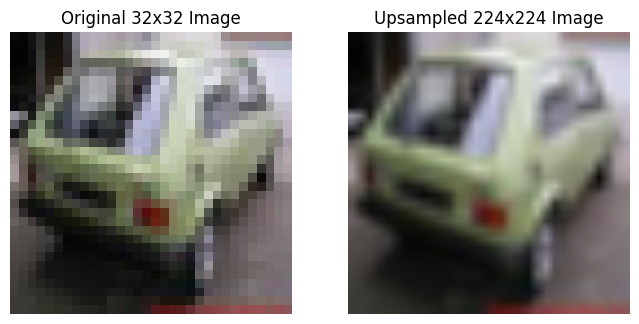

In [332]:

# Fetch a random image index
# random_idx = random.randint(0, len(cifar10) - 1)
random_idx = 1493
print(random_idx)

# Get the image and its label
original_image, label = cifar10[random_idx]

# Convert image to NumPy format
original_image_np = np.array(original_image)

# Define upsampling transform
transform = Resize((224, 224))

upsampled_image_np = scale_up_new(original_image_np)

# Display both images
plt.figure(figsize=(8, 4))

# Original image (32x32)
plt.subplot(1, 2, 1)
plt.title("Original 32x32 Image")
plt.imshow(original_image_np)
plt.axis("off")

# Upsampled image (224x224)
plt.subplot(1, 2, 2)
plt.title("Upsampled 224x224 Image")
plt.imshow(upsampled_image_np)
plt.axis("off")

plt.show()


In [216]:
original_image_np.shape

(32, 32, 3)

# Final pipeline tk

## Model selection

In [173]:
## Hyper
MODEL_TYPE = 3

In [174]:
if MODEL_TYPE == 1:
    state_dict_file = "cifar100_4head.pth"   
    NUM_CLASSES = 100 
elif MODEL_TYPE == 2:
    state_dict_file = "cifar100_1head.pth"
    NUM_CLASSES = 100 
elif MODEL_TYPE == 3:
    state_dict_file = "pretrain_ft_cifar100.pth"
    NUM_CLASSES = 100 
    pass
elif MODEL_TYPE == 4:
    raise Exception("Not implemented yet")
    pass

In [176]:
args = init_parser()
config = {
    "img_size": 32,           # CIFAR-10 image size (32x32)
    #  "img_size": 256, 
    "hflip": True,            # Horizontal flip augmentation (common for CIFAR-10)
    "num_channels": 3,        # CIFAR-10 has 3 channels (RGB)
    # "num_classes": 10,        # CIFAR-10 has 10 classes
    "num_classes": NUM_CLASSES ,        # CIFAR-10 has 10 classes
    "cm": False,  
    
    "dataset":'cifar100',  
    #  "dataset":'cifar10',      
    #     "dataset":'fmnist',
    "padding": 4,             # Typical padding used in CIFAR-10 augmentation
    "mean": [0.4914, 0.4822, 0.4465],  # Precomputed mean values for CIFAR-10 (RGB)
    "std": [0.2023, 0.1994, 0.2010]  ,  # Precomputed standard deviation for CIFAR-10 (RGB)
    "epochs"  : 120 , 
}



update_config(config,type=MODEL_TYPE)

args = update_args(args, config)

# print_args(args)
if MODEL_TYPE in [1,2]:
    model = ViT(args).to(device)
elif MODEL_TYPE == 3:
    # load the other vit
    # model=Pretrained_ViT().to(device)
    model=get_Pretrained_Vit()
    # raise Exception("Not implemented yet")
    # pass
elif MODEL_TYPE == 4:
    # idk
    raise Exception("Not implemented yet")
    pass

model.safetensors:  42%|####2     | 147M/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [177]:

load_model_state_dict(model, relative_path_to_checkpoints=os.path.join('..', 'Pretrained_checkpoints'), filename=state_dict_file)
model.eval()
pass

Model loaded from ..\Pretrained_checkpoints\pretrain_ft_cifar100.pth


In [291]:
img_test_1 = original_image_np
# img_test_1 = images[4]
img_test_1 = img_test_1.transpose(2,0,1)
img_test_1 =  np.expand_dims(img_test_1, axis=0)  
img_test_2 = img_one
img_test_1.shape, img_test_2.shape

((1, 3, 32, 32), (1, 3, 32, 32))

### select image

In [292]:
img_test_1

array([[[[0.03529412, 0.02745098, 0.08627451, ..., 0.60784316,
          0.6       , 0.5882353 ],
         [0.01176471, 0.01176471, 0.06666667, ..., 0.61960787,
          0.60784316, 0.6       ],
         [0.00784314, 0.00784314, 0.05882353, ..., 0.79607844,
          0.7921569 , 0.78431374],
         ...,
         [0.23921569, 0.21960784, 0.20392157, ..., 0.45882353,
          0.45882353, 0.45882353],
         [0.22352941, 0.22745098, 0.22352941, ..., 0.48235294,
          0.50980395, 0.4862745 ],
         [0.23137255, 0.23137255, 0.21568628, ..., 0.5411765 ,
          0.57254905, 0.5372549 ]],

        [[0.03529412, 0.02745098, 0.08627451, ..., 0.5019608 ,
          0.49411765, 0.47843137],
         [0.01176471, 0.01176471, 0.06666667, ..., 0.64705884,
          0.6392157 , 0.627451  ],
         [0.00784314, 0.00784314, 0.05490196, ..., 0.7921569 ,
          0.7882353 , 0.78039217],
         ...,
         [0.23529412, 0.21568628, 0.2       , ..., 0.41960785,
          0.43529412, 0.4

In [293]:
img_test_1.shape, img_test_2.shape

((1, 3, 32, 32), (1, 3, 32, 32))

In [313]:


_img2 =  np.expand_dims(upsampled_image_np.transpose(2,0,1), axis=0)  

In [314]:
'''hyper'''
img_name = 'single'
# img_name = 'combined'

img = select_image(img_name, img_test_1,  img_test_2)
# ------------------
img = _img2

if(MODEL_TYPE==3 or MODEL_TYPE==4) and img.shape[-1] != 224:
    print("scaling")
    img=scale_up(img)

img.shape
type(img)

# out, attns = fetch_attentions(img, model)

numpy.ndarray

In [315]:
img

array([[[[0.03529412, 0.03529412, 0.03529412, ..., 0.5882353 ,
          0.5882353 , 0.5882353 ],
         [0.03529412, 0.03529412, 0.03529412, ..., 0.5882353 ,
          0.5882353 , 0.5882353 ],
         [0.03529412, 0.03529412, 0.03529412, ..., 0.5882353 ,
          0.5882353 , 0.5882353 ],
         ...,
         [0.23137255, 0.23137255, 0.23137255, ..., 0.5372549 ,
          0.5372549 , 0.5372549 ],
         [0.23137255, 0.23137255, 0.23137255, ..., 0.5372549 ,
          0.5372549 , 0.5372549 ],
         [0.23137255, 0.23137255, 0.23137255, ..., 0.5372549 ,
          0.5372549 , 0.5372549 ]],

        [[0.03529412, 0.03529412, 0.03529412, ..., 0.47843137,
          0.47843137, 0.47843137],
         [0.03529412, 0.03529412, 0.03529412, ..., 0.47843137,
          0.47843137, 0.47843137],
         [0.03529412, 0.03529412, 0.03529412, ..., 0.47843137,
          0.47843137, 0.47843137],
         ...,
         [0.22745098, 0.22745098, 0.22745098, ..., 0.34117648,
          0.34117648, 0.3

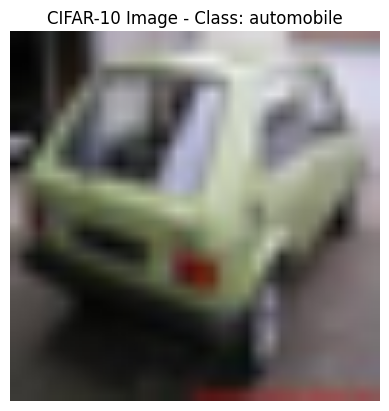

In [316]:
# Plot the image
plt.imshow(img_test_1[0].transpose(1,2,0))
plt.imshow(img[0].transpose(1,2,0))
plt.title(f"CIFAR-10 Image - Class: {cifar10.classes[label]}")
plt.axis("off")
plt.show()

In [317]:
out, attns = fetch_attentions(img, model)

### Get attention heatmaps

In [318]:
attns.shape

torch.Size([12, 12, 197, 197])

MODEL TYPE ==  3
Layer 11, Head 11, Patch 0


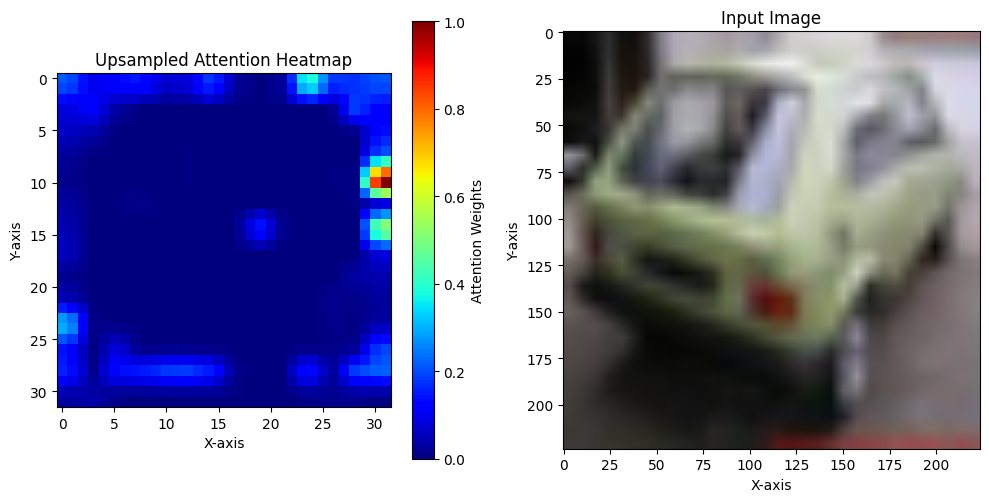

In [350]:
'''hyper'''
head_idx=11
q_idx=0   #0 for cls token
layer_idx=11


# -------------------

print("MODEL TYPE == ",MODEL_TYPE)
print(f"Layer {layer_idx}, Head {head_idx}, Patch {q_idx}")

attn_row = attns[head_idx][layer_idx][q_idx]
# print(attn_row.shape)
threshold = plot_attn_heatmap(attn_row,q_idx, binary=False, threshold='other', figsize = (4,4), normalize_flag=True,overlay=False,quantile_value=0.9,model_type=MODEL_TYPE, img = img.transpose(0,2,3,1))
# threshold = plot_attn_heatmap(attn_row,q_idx, binary=False, threshold='other', figsize = (4,4), normalize_flag=True,overlay=False,quantile_value=0.9,model_type=MODEL_TYPE, img = None)

In [334]:
for i in range(65):
    print(f'{i:02}',end=" ")
    if(i%8==0):
        print()

00 
01 02 03 04 05 06 07 08 
09 10 11 12 13 14 15 16 
17 18 19 20 21 22 23 24 
25 26 27 28 29 30 31 32 
33 34 35 36 37 38 39 40 
41 42 43 44 45 46 47 48 
49 50 51 52 53 54 55 56 
57 58 59 60 61 62 63 64 


In [335]:
pred_idx = out.argmax()
pred_idx, _classes[pred_idx]

(tensor(58), 'elephant')

## Bar chart for classes probability


In [336]:
top_count = 10

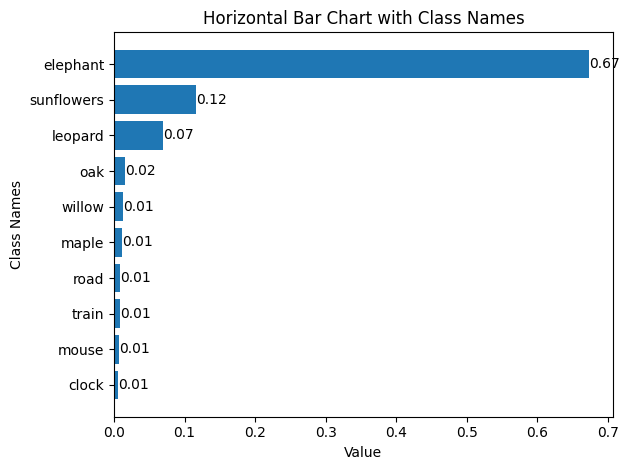

In [337]:
import matplotlib.pyplot as plt

var=nn.Softmax(dim=1)

val = var(out)[0]


# Combine val and titlenames into a list of tuples

# combined = list(zip(val, classes))
combined = list(zip(val, _classes))

# Sort by value in descending order
sorted_combined_raw = sorted(combined, key=lambda x: x[0], reverse=False)
sorted_combined = sorted_combined_raw[-top_count:]

# Unzip the sorted tuples back into val and titlenames
val_sorted, titlenames_sorted = zip(*sorted_combined)

# Plotting the horizontal bar chart
indices = range(len(val_sorted))
plt.barh(indices, val_sorted)
# Annotate bars with the values
for i, (value, name) in enumerate(zip(val_sorted, titlenames_sorted)):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', color='black')
# Set class names as y-axis labels
plt.yticks(indices, titlenames_sorted)

# Set labels and title
plt.ylabel('Class Names')
plt.xlabel('Value')
plt.title('Horizontal Bar Chart with Class Names')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [338]:
# import torch.nn as nn
# from torchvision.datasets import CIFAR100, CIFAR10
# import matplotlib.pyplot as plt

# def bar_char(model_name="CIFAR_10", out=None):
#     var = nn.Softmax(dim=1)
#     val = var(out)[0]

#     # Define classes for CIFAR-100 and CIFAR-10
#     if model_name == "CIFAR_100":
#         classes = classes_100
#     elif model_name == "CIFAR_10":
#         classes = [
#             "airplane", "automobile", "bird", "cat", "deer", 
#             "dog", "frog", "horse", "ship", "truck"
#         ]

#     # Combine val and classes into a list of tuples
#     combined = list(zip(val, classes))

#     # Sort by value in descending order and take top 10
#     sorted_combined = sorted(combined, key=lambda x: x[0], reverse=True)[:10]

#     # Unzip the sorted tuples back into val and classes
#     val_sorted, classes_sorted = zip(*sorted_combined)

#     # Plotting the horizontal bar chart
#     indices = range(len(val_sorted))
#     plt.barh(indices, val_sorted, color='skyblue')
    
#     # Annotate bars with the values
#     for i, (value, name) in enumerate(zip(val_sorted, classes_sorted)):
#         plt.text(value, i, f'{value:.2f}', va='center', ha='left', color='black')
    
#     # Set class names as y-axis labels
#     plt.yticks(indices, classes_sorted)

#     # Set labels and title
#     plt.ylabel('Class Names')
#     plt.xlabel('Probability')
#     plt.title(f'Top 10 Classes by Probability ({model_name})')

#     # Show the plot
#     plt.tight_layout()  # Adjust layout to prevent overlapping
#     plt.show()
# bar_char(model_name="CIFAR_10",out=out)

# End of File

In [339]:
print("End of file")

End of file
